In [1]:
from dotenv import load_dotenv
import os

load_dotenv('./.env', override=True)

def_vars = [
    'DATABASE_USER', 'DATABASE_PASS', 
    'DATABASE_HOST', 'DATABASE_PORT', 
    'DATABASE_NAME', 'GROQ_API_KEY'
]

def get_env_object():
    return { x: os.environ[x] for x in def_vars }

env_object = get_env_object()

In [2]:
import yaml
import json
import time

def read_file(fp: str) -> str:
    with open(fp, "r+", encoding="UTF-8") as o:
        return o.read()


def read_yaml(fp: str):
    return yaml.safe_load(read_file(fp))

def save_dict_as_file(fp:str, d:dict):
    with open(fp, "w") as y:
        yaml.dump(d, y)


In [3]:
import psycopg2
from psycopg2 import sql


class DbConnectionManager:
    def __init__(self, env_object ,init_sql_folder: str = None):
        self.e_o = env_object
        self.con = None
        self.cur = None
        
        if init_sql_folder:
            print("will create default objects")
            self.init_db(init_sql_folder)
            print("successfully created")
    
    def _call_func(self, func_name: str, params: list[str], **kwargs):

        commit = kwargs.get("commit") or False
        res = kwargs.get("ret_result") or False

        q = sql.SQL("""
            select {func_name}({params_list});
        """).format(
            func_name=sql.Identifier(func_name),
            params_list= sql.SQL(', ').join(
                [sql.Literal(x) for x in params])
        )

        return self._execute_query(q, commit=commit, ret_result=res)
    
    def try_save_query(self, view_name:str, query: str) -> bool:
        ret = self._call_func(
            'f_save_query_as_view',
            [view_name, query],
            commit=True,
            ret_result=True
        )
        return ret[0][0]
    
    def check_generated_query(self, corr_view: str, tested_view: str) -> dict:
        ret = self._call_func(
            'f_check_generated_query',
            [corr_view, tested_view],
            ret_result=True
        )
        return ret[0][0]
    

    def init_db(self, init_sql_folder: str) -> None:
        if not os.path.exists(init_sql_folder):
            raise Exception("init sql folder does not exists")
        
        for f in os.listdir(init_sql_folder):
            fp = os.path.abspath(
                os.path.join(init_sql_folder, f)
            )

            fc = read_file(fp)
            
            self._execute_query(fc, commit=True)


    def _execute_query(self, query:str, commit=False, ret_result=False):
        cur, con = self._get_connection()

        cq = query
        if isinstance(query, sql.Composed):
            cq = query.as_string(cur)

        try:
            cur.execute(cq)
        except Exception as e:
            print(e)
            return None
        
        if commit:
            con.commit()

        if ret_result:
            return cur.fetchall()
        
        return None

    def _is_con_set(self):
        return self.cur is not None and self.con is not None
        
    def _get_connection(self):
        if self._is_con_set():
            return (self.cur, self.con)
        
        con_str = self._get_con_string()
        self.con = psycopg2.connect(con_str)
        self.cur = self.con.cursor()
        return (self.cur, self.con)
    
    def __del__(self):
        if self._is_con_set():
            self.cur.close()
            self.con.close()
        
    
    def _get_con_string(self):
        return "host='%s' dbname='%s'\
            user='%s' password='%s'" % (
                self.e_o["DATABASE_HOST"],
                self.e_o["DATABASE_NAME"],
                self.e_o["DATABASE_USER"],
                self.e_o["DATABASE_PASS"]
            )



In [4]:
import abc

class LLMProvider(metaclass=abc.ABCMeta):

    @staticmethod
    def __subclasshook__(cls, subclass):
        return (
                hasattr(subclass, "generate_sql") and 
                callable(subclass, "generate_sql") and 

                hasattr(subclass, "get_service_name") and 
                callable(subclass, "get_service_name") or
                
                NotImplemented
        )

    def generate_sql(self, user_query: str) -> str:
        """ Generate sql. Prompt should be known to class """
        raise NotImplementedError
    
    def get_service_name(self) -> str:
        """ Return service name. 
            E.g for Lamini LLM, will return lamini
        """
        raise NotImplementedError

In [5]:
class LLMResultComparator:
    def __init__(
            self,
            data_folder: str,
            db_manager: DbConnectionManager):
        
        self.db_manager = db_manager
        self.df = data_folder
        self._init_db_with_cases()

    
    def compute_accuracy(self, llm: LLMProvider):

        gen_q = {}
        tc: dict = self.tc
        sn = llm.get_service_name()

        print("start getting generated queries")
        for x in tc:
            data: dict = tc.get(x)
            print(f"processing {x}")
            try:
                gen_q[x] = llm.generate_sql(data.get("user_query"))
            except Exception as e:
                print(e)
                # если ошибка при генерации - считаем, что нам сгенерировали невалидный sql
                gen_q[x] = "select * from not_exists_table"
        
        # на всякий случай
        print("dump generated queries to file")
        fn = f"{self.df}/{sn}.yaml"
        save_dict_as_file(fn, gen_q)

        return self._check_results(gen_q, sn)
    
    def recompute_accuracy(self, fn:str, sn: str) -> dict:
        generated_queries = read_yaml(fn)
        return self._check_results(generated_queries, sn)

    
    def _check_results(self, generated_queries: dict, sn: str) -> dict:
        tc :dict = self.tc
        stats = {}
        for x in tc:
            vn = self._get_gen_view_name(x, sn)
            try:
                sr = self.db_manager.try_save_query(
                    vn,
                    generated_queries.get(x)
                )
            except:
                print("failed to save query")
                sr = None

            if not sr:
                stats[x] = {
                    "status": "failed",
                    "reason": "query not executable"
                }
                continue
            
            comp_res = self.db_manager.check_generated_query(
                self._get_correct_view_name(x),
                vn
            )

            res = self._analyze_query_comp(comp_res)
            stats[x] = {
                "status": res["status"],
                "reason": res["description"]
            }

        return stats


    def _analyze_query_comp(self, comp_res: dict) -> dict:
        res = {
            "status":"",
            "description":""
        }

        acm: int= comp_res.get("attr_count_mismatch")
        rcm: int = comp_res.get("rows_count_mismatch")
        chm: list[str] = comp_res.get("cols_hashes_mismatch")

        acm_mes: str = "attribute count mismatch"
        rcm_mes: str = "rows count mismatch"
        chm_mes: str = "execution results differs"

        #if (acm == 0 and rcm == 0 and chm == []):
        # если rcm ==0 , chm == [], а acm != 0, это означает, что 
        # модель написала запрос, который возвращает больше атрибутов, чем эталонный
        # такие запросы мы НЕ будем считать за ошибочные
        if (rcm == 0 and chm == []):
            res["status"] = "success"
        else:
            res["status"] = "failed"
            desc = []

            if acm != 0:
                desc.append(acm_mes)
            if rcm != 0:
                desc.append(rcm_mes)
            if chm != []:
                desc.append(chm_mes)
            
            res["description"] = ';'.join(desc)

        return res


    def _get_correct_view_name(self, test_case: str) -> str:
        return f"v_{test_case}"
    
    def _get_gen_view_name(self, test_case: str, service_name: str) -> str:
        return f"{service_name}_{test_case}"

    def _init_db_with_cases(self):
        tc = read_yaml(f"{self.df}/main.yaml")["test_cases"]

        # если будет просадка по скорости не забыть добавить пред проверку
        # на инит базы
        for x in tc:
            data = tc.get(x)
            fn = self._get_correct_view_name(x)
            res = self.db_manager.try_save_query(fn, data.get("correct_query"))
            if not res:
                print(f"failed to save {fn}")
                print(data.get("correct_query"))
        
        self.tc = tc





In [44]:
class DummyLLM(LLMProvider):
    """
    Class only for test and concept purpose
    """

    def __init__(self, context_manager):
        self.pr = context_manager

    def generate_sql(self, user_query: str) -> str:
        if 'видеоигры' in user_query:
            return 'select id from video_games.game'
        else:
            return 'select * from video_games.genre'
    
    def get_service_name(self) -> str:
        return "dummy"

In [6]:
from groq import Groq

client = Groq(
    api_key=env_object.get("GROQ_API_KEY"),
)

In [7]:
class GroqLLMProvider(LLMProvider):
    """
    https://groq.com/
    NEED VPN!!!
    """
    def __init__(self, context_manager, client: Groq):
        self.client = client
        self.pr = context_manager
    
    def set_model(self, model: str, model_name: str):
        self.model = model
        self.model_name = model_name

    def generate_sql(self, user_query: str) -> str:
        print("sleep to be nice to service")
        time.sleep(10)
        print("start proceeding requests")
        comp = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {
                    "role": "system",
                    "content": self.pr.get_context()
                },
                {
                    "role": "user",
                    "content": user_query
                },
            ],
            temperature=1,
            max_completion_tokens=1024,
            top_p=1,
            stream=False,
            response_format={"type": "json_object"},
            stop=None,
        )

        mes = comp.choices[0].message
        mes = json.loads(mes.content)
        return mes.get(*mes.keys())
    
    def get_service_name(self) -> str:
        return self.model_name

In [8]:
class DefaultContextManager:
    def __init__(self, m_folder: str):
        if not os.path.exists(m_folder):
            raise Exception("missing file with context")

        self.context = read_file(f"{m_folder}/default.txt")
    
    def get_context(self):
        return self.context


In [9]:
db_manager = DbConnectionManager(env_object, './init_sql')

will create default objects
successfully created


In [10]:
f = LLMResultComparator("test_data", db_manager)

In [91]:
test_res = f.compute_accuracy(DummyLLM(DefaultContextManager("./contexts")))

start getting generated queries
dump generated queries to file


In [92]:
test_res

{'test_1': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_2': {'status': 'success', 'reason': ''}}

In [61]:
res1 = db_manager.check_generated_query("test_001", "test_1102")

In [82]:
res1

{'attr_count_mismatch': 0,
 'rows_count_mismatch': -53960,
 'cols_hashes_mismatch': ['25265c47e5182330fe2e74235c5a1e75',
  '38654549aaf1f3e0eb259e9cc3902cfd',
  '098c1ebc8d18a24e4958e06122877b86']}

In [16]:
context_manager = DefaultContextManager("./contexts")

In [27]:
models = [
    ("llama-3.3-70b-versatile","llama-3-3-70b"),
    ("qwen-2.5-coder-32b","qwen-coder"),
    ("gemma2-9b-it","gemma2"),
    ("mixtral-8x7b-32768","mixtral"),
    ("whisper-large-v3", "whisper"),
    ("deepseek-r1-distill-qwen-32b","deepseek-qwen"),
    ("deepseek-r1-distill-llama-70b", "deepseek-llama"),
    ("llama3-8b-8192", "llama3-8b-8192"),
    ("llama-3.1-8b-instant", "llama-3-1-8b"),
    ("mistral-saba-24b", "mistral")
    ]


In [14]:
Llama33 = GroqLLMProvider(context_manager, client)

In [15]:
Llama33.set_model(models[0][0], models[0][1])


In [ ]:
test_res = f.compute_accuracy(Llama33)

In [67]:
test_res

{'test_1': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_2': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_3': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_4': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_5': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_6': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_7': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_8': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_9': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_10': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_11': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_12': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_13': {'status': 'failed', 'reason': 'attribute count mismatch'},
 'test_14': {'sta

In [16]:
test_res_recomputed = f.recompute_accuracy('./test_data/llama-3-3-70b.yaml', 'llama-3-3-70b')

In [17]:
test_res_recomputed
save_dict_as_file('./results/llama3-3-70b', test_res_recomputed)

In [53]:
Llama33.set_model(models[1][0], models[1][1])

In [54]:
test_res = f.compute_accuracy(Llama33)

start getting generated queries
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding requests
sleep to be nice to service
start proceeding reque

In [55]:
test_res

{'test_1': {'status': 'success', 'reason': ''},
 'test_2': {'status': 'success', 'reason': ''},
 'test_3': {'status': 'success', 'reason': ''},
 'test_4': {'status': 'success', 'reason': ''},
 'test_5': {'status': 'success', 'reason': ''},
 'test_6': {'status': 'success', 'reason': ''},
 'test_7': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_8': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_9': {'status': 'success', 'reason': ''},
 'test_10': {'status': 'success', 'reason': ''},
 'test_11': {'status': 'success', 'reason': ''},
 'test_12': {'status': 'success', 'reason': ''},
 'test_13': {'status': 'success', 'reason': ''},
 'test_14': {'status': 'failed', 'reason': 'execution results differs'},
 'test_15': {'status': 'success', 'reason': ''},
 'test_16': {'status': 'success', 'reason': ''},
 'test_17': {'status': 'success', 'reason': ''},
 'test_18': {'status': 'success', 'reason': ''},
 

In [64]:
Llama33.set_model(models[2][0], models[2][1])
test_res = f.compute_accuracy(Llama33)

start getting generated queries
processing test_1
sleep to be nice to service
start proceeding requests
processing test_2
sleep to be nice to service
start proceeding requests
processing test_3
sleep to be nice to service
start proceeding requests
processing test_4
sleep to be nice to service
start proceeding requests
processing test_5
sleep to be nice to service
start proceeding requests
processing test_6
sleep to be nice to service
start proceeding requests
processing test_7
sleep to be nice to service
start proceeding requests
processing test_8
sleep to be nice to service
start proceeding requests
processing test_9
sleep to be nice to service
start proceeding requests
processing test_10
sleep to be nice to service
start proceeding requests
processing test_11
sleep to be nice to service
start proceeding requests
processing test_12
sleep to be nice to service
start proceeding requests
processing test_13
sleep to be nice to service
start proceeding requests
processing test_14
sleep to 

In [65]:
test_res

{'test_1': {'status': 'success', 'reason': ''},
 'test_2': {'status': 'success', 'reason': ''},
 'test_3': {'status': 'success', 'reason': ''},
 'test_4': {'status': 'success', 'reason': ''},
 'test_5': {'status': 'success', 'reason': ''},
 'test_6': {'status': 'success', 'reason': ''},
 'test_7': {'status': 'failed', 'reason': 'execution results differs'},
 'test_8': {'status': 'failed',
  'reason': 'attribute count mismatch;execution results differs'},
 'test_9': {'status': 'success', 'reason': ''},
 'test_10': {'status': 'success', 'reason': ''},
 'test_11': {'status': 'success', 'reason': ''},
 'test_12': {'status': 'success', 'reason': ''},
 'test_13': {'status': 'success', 'reason': ''},
 'test_14': {'status': 'success', 'reason': ''},
 'test_15': {'status': 'success', 'reason': ''},
 'test_16': {'status': 'success', 'reason': ''},
 'test_17': {'status': 'success', 'reason': ''},
 'test_18': {'status': 'success', 'reason': ''},
 'test_19': {'status': 'failed', 'reason': 'query no

In [20]:
Llama33.set_model(models[3][0], models[3][1])
test_res = f.recompute_accuracy('./test_data/mixtral.yaml', models[3][1])
save_dict_as_file('./results/mixtral', test_res)

failed to save query
failed to save query


In [29]:
models = [
    ("llama-3.2-1b-preview","llama-3-2-1b"),
    ]

In [30]:
for x in models:
    model_name, short_name = x[0], x[1]
    print(f"processing {short_name}")
    Llama33.set_model(model_name, short_name)
    test_res = f.compute_accuracy(Llama33)
    print(f"queries generated for {short_name}")
    save_dict_as_file(f'./results/{short_name}', test_res)
    print(f"results saved for {short_name}")

processing llama-3-2-1b
start getting generated queries
processing test_1
sleep to be nice to service
start proceeding requests
processing test_2
sleep to be nice to service
start proceeding requests
Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{\n   "genre": [\n      {"id": 1, "name": "Action"},\n      {"id": 2, "name": "Adventure"},\n      {"id": 3, "name": "Strategy"},\n      {"id": 4, "name": "Roleplaying}")\n}}'}}
processing test_3
sleep to be nice to service
start proceeding requests
processing test_4
sleep to be nice to service
start proceeding requests
processing test_5
sleep to be nice to service
start proceeding requests
processing test_6
sleep to be nice to service
start proceeding requests
processing test_7
sleep to be nice to service
start proceeding requests
Error code: 400 - {'error': {'message'

In [20]:
model_to_recompute = [
    ('./test_data/mistral.yaml', 'mistral'),
]

for m in model_to_recompute:
    test_res_recomputed = f.recompute_accuracy(m[0], m[1])
    save_dict_as_file(f'./results/{m[1]}.yaml', test_res_recomputed)

## Аналитика

In [13]:
!pip install pandas

  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
     --------------------------------------- 12.9/12.9 MB 27.3 MB/s eta 0:00:00
     ------------------------------------- 507.9/507.9 kB 31.1 MB/s eta 0:00:00
     ------------------------------------- 346.8/346.8 kB 21.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
FAILURE_REASONS = {
    "overcomplicated": 
              {
                  "description": "Переусложнил запрос. Вывел лишнию информацию/сделал больше, чем требовалось",
                  "count_as_success":   True
              },
    "logical_error": 
              {
                  "description": "Логически неверный запрос. Не учел какое-то условие",
                  "count_as_success": False
              },
    "schema_understanding_error": 
              {
                  "description": "Не понял взаимосвязь таблицы",
                  "count_as_success": False
              },
    "added_ordering": 
              {
                  "description": "Добавил лишную сортировку",
                  "count_as_success": True
              },
    "syntax_error": 
              {
                  "description": "Некорректный синтаксис",
                  "count_as_success": False
              },
    "forgot_schema": 
              {
                  "description": "Забыл добавить обращения к схемам у таблиц",
                  "count_as_success": True
              },
    "generation_failed":
              {
                  "description": "Модель не смогла сгенерировать запрос",
                  "count_as_success": False
              }

}

In [4]:
import pandas as pd


def get_status(d: dict):
    if d["status"].lower() == "failed":
        if ('processed_reason' not in d):
                return "generation_failed"
        return d['processed_reason']
    return d["status"]
              

def get_dataset_from_results(path: str, main_file_p: str):

    main_file = read_yaml(main_file_p)
    difficulties = [x["difficulty"] for _,x in main_file["test_cases"].items()]

    data = {}
    for f in os.listdir(path):
        file_path = os.path.join(path, f)
        yaml_data = read_yaml(file_path)
        tests = {}
        for test_name, test_info in yaml_data.items():
                    # Add the status of the test to the test data
                    tests[test_name] = get_status(test_info)
        data[f.split('.')[0]] = tests

    data_list = []
    test_names = set()
    for filename, test_data in data.items():
        test_names.update(test_data.keys())

    test_names = list(test_names)
    test_names.sort(key=lambda x: int(x.split('_')[1]))

    for test_name in test_names:
        test_dict = {}
        for filename, test_info in data.items():
            if test_name in test_info:
                test_dict[filename] = test_info[test_name]
            else:
                test_dict[filename] = ''
        data_list.append({**{'test_name': test_name}, **test_dict})

    df = pd.DataFrame(data_list)

    df = df.set_index('test_name')
    df["difficulty"] = difficulties
    return df

In [5]:
df = get_dataset_from_results('./results', './test_data/main.yaml')
df

,deepseek-llama,deepseek-qwen,gemma2,llama-3-1-8b,llama-3-2-1b,llama3-3-70b,llama3-8b-8192,mistral,mixtral,qwen-coden,difficulty
test_name,,,,,,,,,,,
test_1,syntax_error,success,success,generation_failed,generation_failed,success,success,forgot_schema,generation_failed,success,1
test_2,success,success,success,success,generation_failed,success,forgot_schema,success,generation_failed,success,1
test_3,success,success,success,success,generation_failed,success,success,success,generation_failed,success,1
test_4,success,success,success,success,generation_failed,success,success,logical_error,generation_failed,success,1
test_5,success,logical_error,success,generation_failed,generation_failed,success,success,success,generation_failed,success,1
test_6,success,success,success,success,generation_failed,success,success,success,generation_failed,success,2
test_7,logical_error,logical_error,logical_error,syntax_error,generation_failed,overcomplicated,logical_error,forgot_schema,generation_failed,logical_error,2
test_8,success,logical_error,logical_error,generation_failed,generation_failed,overcomplicated,success,success,generation_failed,success,2
test_9,success,success,success,generation_failed,generation_failed,success,success,success,generation_failed,success,1


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, test_1 to test_50
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   deepseek-llama  50 non-null     object
 1   deepseek-qwen   50 non-null     object
 2   gemma2          50 non-null     object
 3   llama-3-1-8b    49 non-null     object
 4   llama-3-2-1b    50 non-null     object
 5   llama3-3-70b    50 non-null     object
 6   llama3-8b-8192  50 non-null     object
 7   mistral         50 non-null     object
 8   mixtral         50 non-null     object
 9   qwen-coden      50 non-null     object
 10  difficulty      50 non-null     int64 
dtypes: int64(1), object(10)
memory usage: 4.7+ KB


In [7]:
! pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 1.7 MB/s eta 0:00:00
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 72.0/72.0 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 3.6 MB/s eta 0:00:00
     ------------------------------------ 107.7/107.7 kB 367.8 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import matplotlib.pyplot as plt
import numpy as np

columns = [col for col in df.columns if col not in ['difficulty']]

def show_rate_histogram(s_val_list: list[str], h_title: str):


    counts_s = [(df[col].isin(s_val_list)).sum() for col in columns]


    x = np.arange(len(columns))
    width = 0.35

    _, ax = plt.subplots(figsize=(15, 6))

    rects_s = ax.bar(x - width/2, counts_s, width, label='success')

    for i, rect in enumerate(rects_s):
        rect.set_facecolor(plt.cm.tab20(i))


    ax.set_xlabel('Column')
    ax.set_ylabel('Correct queries')
    ax.set_title(h_title)
    ax.set_xticks(x)
    ax.set_xticklabels(columns, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

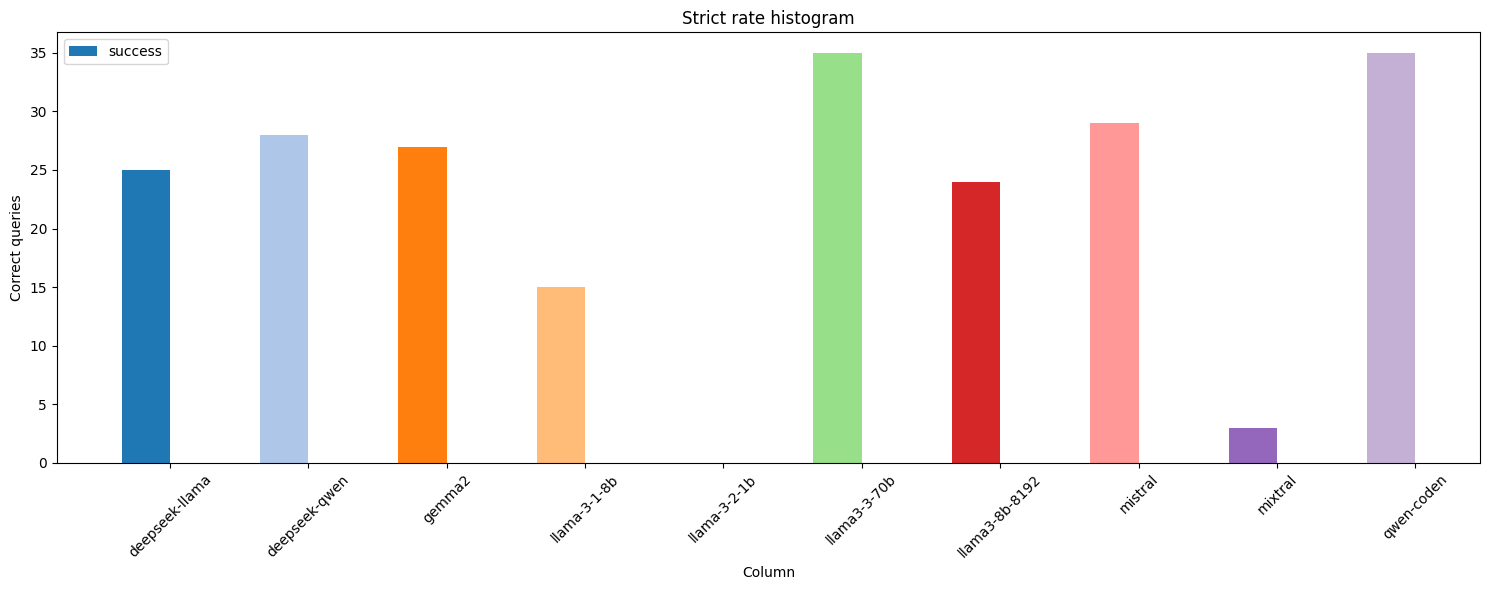

In [30]:
show_rate_histogram(['success'], 'Strict rate histogram')

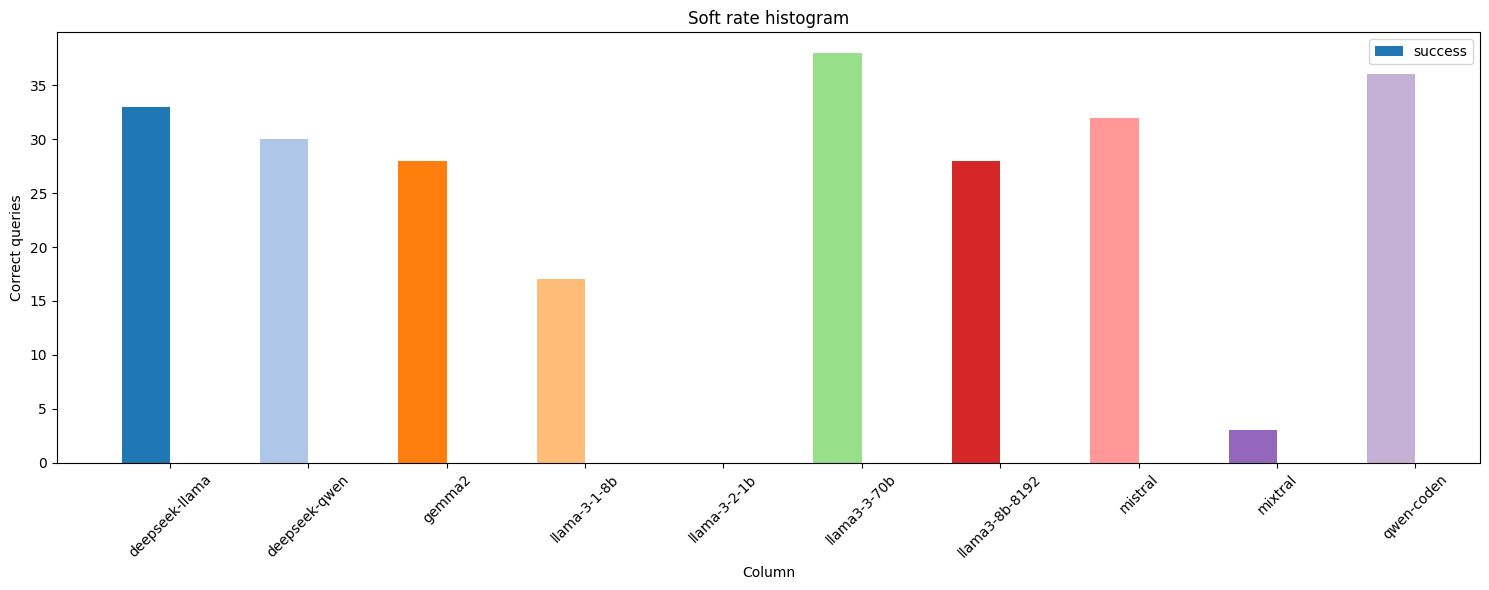

In [37]:
soft_lst = [ k for k,v in FAILURE_REASONS.items() if v["count_as_success"]] + ['success']
show_rate_histogram(soft_lst, 'Soft rate histogram')

In [ ]:

def show_distribution(s_list: list[str]):

    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

    for i, col in enumerate(df.columns[:-1]):
        row = i // 5
        col_pos = i % 5
        rnge = sorted(df['difficulty'].unique())
        counts = []
        for bin in rnge:
            count = ((df['difficulty'] == bin) & (df[col].isin(s_list))).sum()
            counts.append(count)
        axes[row, col_pos].bar(range(1, 7), counts)
        axes[row, col_pos].set_title(f'Histogram for {col}')
        axes[row, col_pos].set_xlabel('Difficulty')
        axes[row, col_pos].set_ylabel('Frequency')
        axes[row, col_pos].set_xticks(rnge)

    plt.tight_layout()
    plt.show()

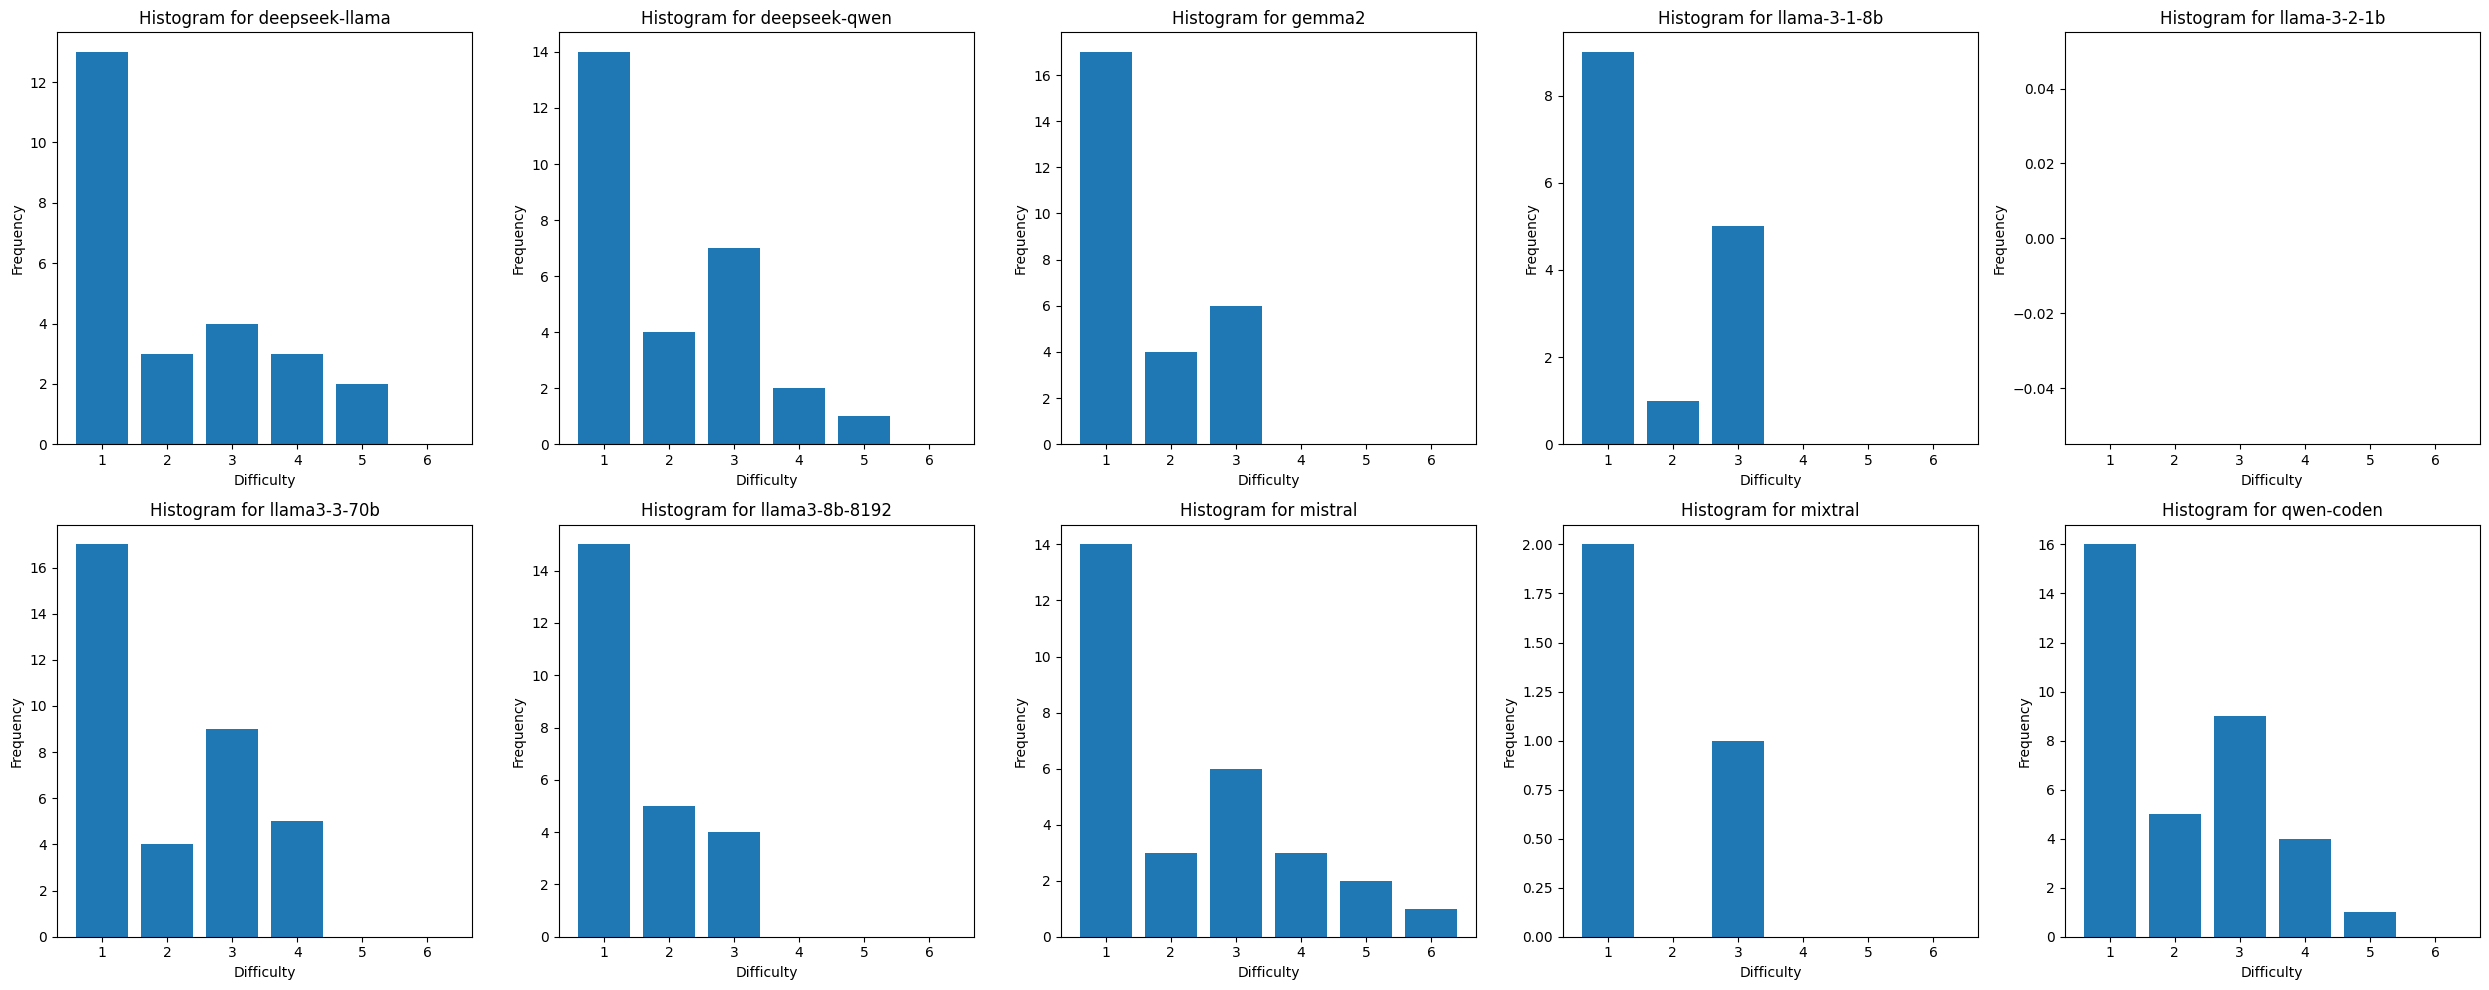

In [36]:
show_distribution(['success'])

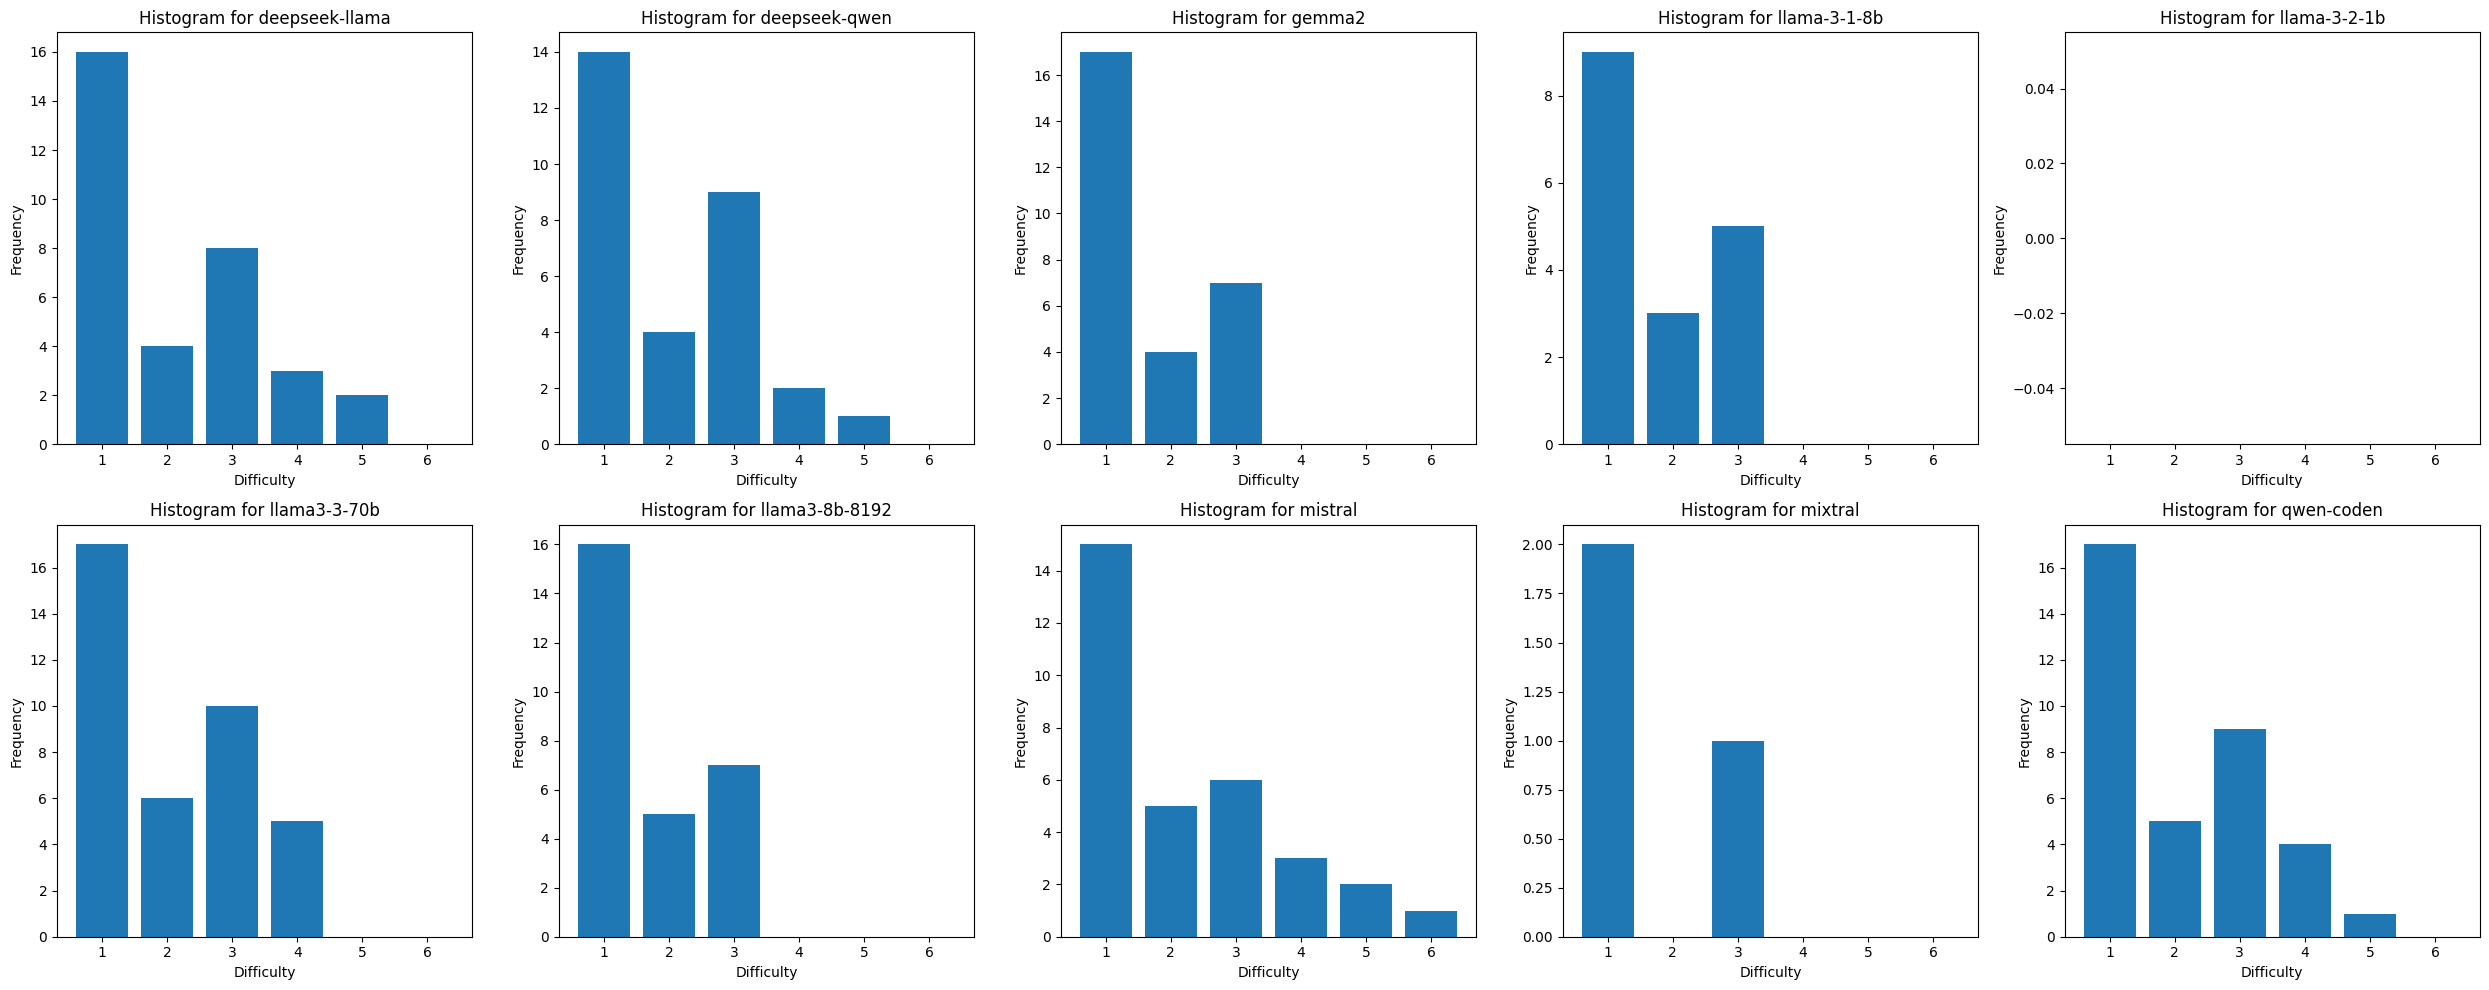

In [38]:
show_distribution(soft_lst)